In [1]:
import sys
sys.path.insert(0, '/home/student.unimelb.edu.au/shorte1/Documents/TINT')

# Core
import datetime
import os
import glob
import tempfile
import pickle
import copy

# Analysis
import numpy as np
import pandas as pd
import xarray as xr

# Plotting
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import rcParams

# Debugging
import pdb, traceback
# %load_ext line_profiler

# Radar Tools
import pyart
import tint
# import tint.animate
# from tint.visualisation import animate

import classification as cl
import CPOL_func as cf
import caine_func as caf
import analysis

# Convenience functions
%load_ext autoreload
%autoreload 1
%aimport CPOL_func
%aimport caine_func
%aimport tint.visualisation.figures
%aimport tint.visualisation.animate
%aimport tint.visualisation.horizontal_helpers
%aimport tint.visualisation.vertical_helpers
%aimport tint.tracks
%aimport tint.objects
%aimport tint.grid_utils
%aimport tint.steiner
%aimport tint.matching
%aimport tint.rain
%aimport tint.cells
%aimport tint.tracks_helpers
%aimport tint.process_ERA5
%aimport tint.process_WRF

%pdb

base_dir = '/media/shorte1/Ewan\'s Hard Drive/phd/data/CPOL/'
save_dir = '/home/student.unimelb.edu.au/shorte1/Documents/TINT_tracks/'
fig_dir = '/home/student.unimelb.edu.au/shorte1/Documents/TINT_figures/'
ERA5_dir = '/media/shorte1/Ewan\'s Hard Drive/phd/data/era5/'
ERA5_dir += 'pressure-levels/reanalysis/'
WRF_dir = '/media/shorte1/Ewan\'s Hard Drive/phd/data/caine_WRF_data/'


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



/home/student.unimelb.edu.au/shorte1/anaconda3/envs/CPOL_analysis/lib/python3.8/site-packages/networkx/readwrite/graphml.py:346: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  (np.int, "int"), (np.int8, "int"),
/home/student.unimelb.edu.au/shorte1/anaconda3/envs/CPOL_analysis/lib/python3.8/site-packages/networkx/readwrite/gexf.py:220: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to us

Automatic pdb calling has been turned ON


# Load Tracks

In [2]:
with open(save_dir + 'ACCESS_63/20201001_20210501.pkl', 'rb') as f:
    tracks_obj = pickle.load(f)

In [30]:
tracks_obj.tracks.xs(np.datetime64('2020-12-20T00:10'), level='time')['u_shift']

scan   uid  level
11458  611  0       -14.139
            1       -14.139
       612  0       -12.750
            1       -12.750
       613  0         2.083
            1         2.083
       614  0         4.167
            1         4.167
Name: u_shift, dtype: float64

In [25]:
plot_datetime = np.datetime64('2020-12-20 00:10:00')

ACCESS_refl, grid = tint.process_ACCESS.init_ACCESS_C(plot_datetime, tracks_obj.reference_grid, gadi=False)

Generating figure for 2020-12-20T00:10.


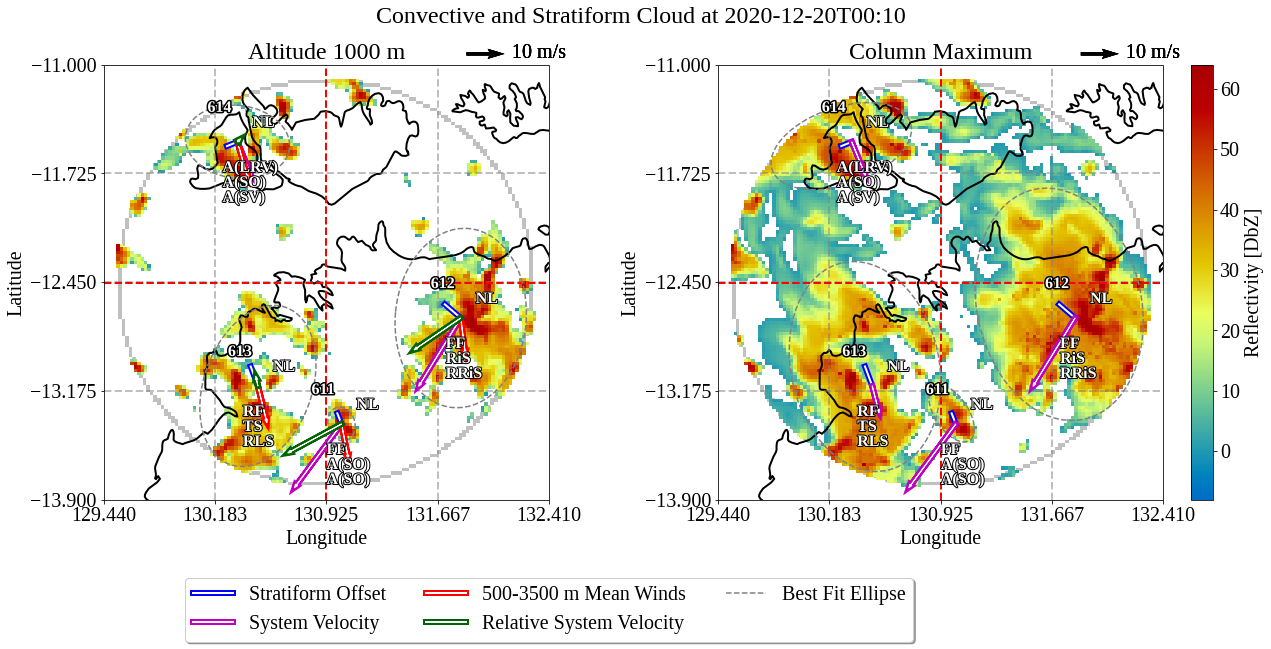

In [26]:
# filename = filenames[12]
# grid = pyart.io.read_grid(filename, include_fields=['reflectivity'])

# ACCESS_refl = tint.process_ACCESS.

current_time = str(datetime.datetime.now())[0:-7]
current_time = current_time.replace(" ", "_").replace(":", "_")
current_time = current_time.replace("-", "")

params = {
    'uid_ind': None, 'line_coords': False, 'center_cell': False,
    'cell_ind': 10, 'winds': False,
    'crosshair': True, 'fontsize': 20, 'colorbar_flag': True,
    'leg_loc': 2, 'label_type': 'velocities',
    'system_winds': ['shift', 'ambient_mean', 'relative'],
    'boundary': True, 'exclude': False}

tint.visualisation.figures.two_level(
    tracks_obj, grid, params=params, alt1=0, alt2=1)
plt.savefig(
    fig_dir + '/test_{}.png'.format(current_time), 
    dpi=200, facecolor='w', edgecolor='white', bbox_inches='tight')

In [270]:
with open(save_dir + '/lin.pkl', 'rb') as f:
    tracks_obj = pickle.load(f)

In [271]:
tracks_obj.params['DT'] = 10
tracks_obj.params['CLASS_THRESH'] = {
    'OFFSET_MAG': 10000,  # metres
    'SHEAR_MAG': 2,  # m/s
    'VEL_MAG': 5,  # m/s
    'REL_VEL_MAG': 2,  # m/s
    'ANGLE_BUFFER': 10}
tracks_obj.params['EXCL_THRESH'] = {
    'SMALL_AREA': 500,  # km^2
    'LARGE_AREA': 50000,  # km^2
    'BORD_THRESH': 0.001,  # Ratio border pixels to total pixels
    'MAJOR_AXIS_LENGTH': 25,  # km
    'AXIS_RATIO': 2,
    'DURATION': 30}  # minutes
tracks_obj = tint.objects.get_system_tracks(tracks_obj)
tracks_obj = tint.objects.classify_tracks(tracks_obj)
tracks_obj = tint.objects.get_exclusion_categories(tracks_obj)

Calculating system tracks.


In [27]:
# dates = np.arange(
#     np.datetime64('2005-10-01 00:00'), 
#     np.datetime64('2006-05-01 00:00'),
#     np.timedelta64(10, 'm'))

# filenames, start_time, end_time = cf.CPOL_files_from_datetime_list(
#     dates, base_dir=base_dir)

# micro_physics = 'cpol'

b_path = '/home/student.unimelb.edu.au/shorte1/Documents/'
b_path += 'CPOL_analysis/circ_b_ind_set.pkl'
with open(b_path, 'rb') as f:
    b_ind_set = pickle.load(f)

In [7]:
exclusions = [
    'small_area', 'large_area', 'intersect_border', 
    'intersect_border_convective', 'duration_cond', 
    'small_velocity', 'small_offset']

excluded = tracks_obj.exclusions[exclusions]
excluded = excluded.xs(0, level='level')
excluded = np.any(excluded, 1)
# excluded = excluded.where(excluded==False).dropna()
# len(excluded)/3

included = np.logical_not(excluded)
included = included.where(included==True).dropna()
scans = included.loc[:, slice(start_time, end_time), :]
scans = sorted(np.unique(scans.index.get_level_values(0).values))

In [58]:
included

scan   time                 uid 
394    2005-11-12 18:30:00  29      True
395    2005-11-12 18:40:00  29      True
396    2005-11-12 18:50:00  29      True
397    2005-11-12 19:00:00  29      True
398    2005-11-12 19:10:00  29      True
                                    ... 
23852  2006-04-28 08:30:00  2153    True
23853  2006-04-28 08:40:00  2153    True
23854  2006-04-28 08:50:00  2153    True
23855  2006-04-28 09:00:00  2153    True
23856  2006-04-28 09:10:00  2153    True
Length: 1025, dtype: object

In [57]:
len(np.unique(included.index.get_level_values('uid').values))

131

In [272]:
micro_physics = 'lin'

dates = np.arange(
    np.datetime64('2006-02-08 12:00'), 
    np.datetime64('2006-02-13 10:10'),
    np.timedelta64(10, 'm'))

filenames, start_time, end_time = caf.caine_files_from_datetime_list(
    dates, micro_physics=micro_physics, 
    base_dir=WRF_dir)

Gathering files.


In [231]:
filenames[59]

"/media/shorte1/Ewan's Hard Drive/phd/data/caine_WRF_data/lind04_ref/lind04_ref_2006-02-09T09:50:00.nc"

In [273]:
tracks_obj.params['INPUT_TYPE'] = None
tracks_obj.params['WIND_LEVELS'] = tracks_obj.params['LEVELS']

Generating figure for 2006-02-09T09:50.


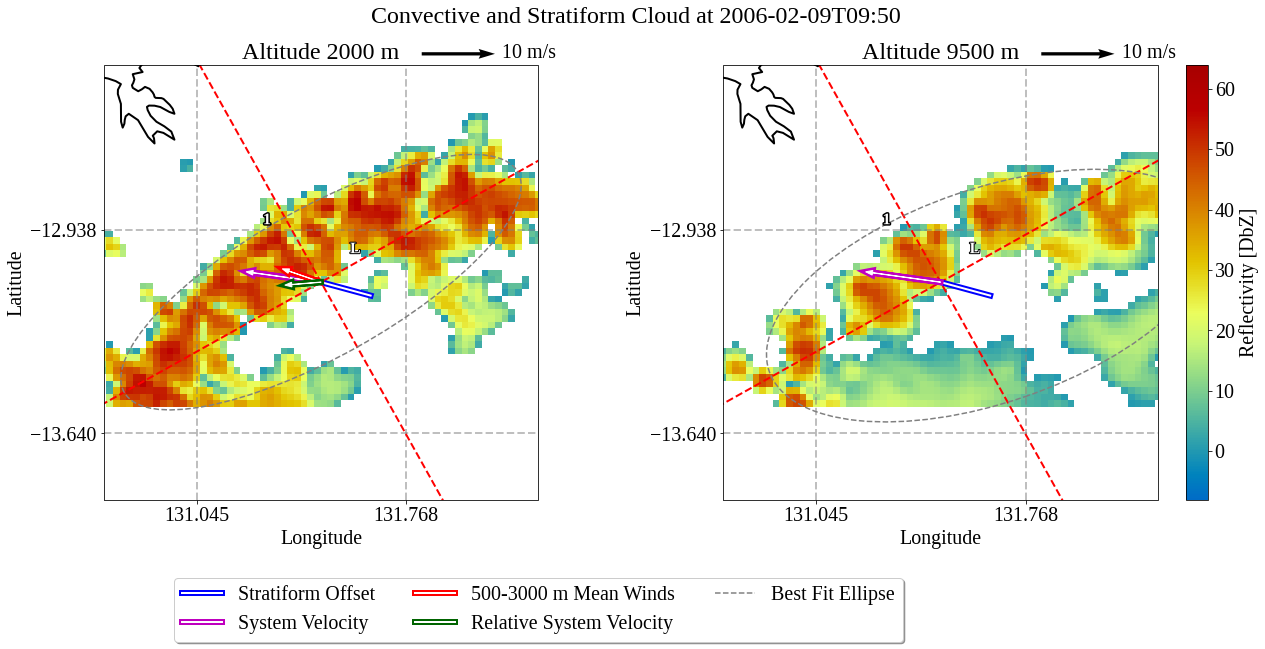

In [274]:
filename = filenames[59]
grid = pyart.io.read_grid(filename, include_fields=['reflectivity'])

current_time = str(datetime.datetime.now())[0:-7]
current_time = current_time.replace(" ", "_").replace(":", "_")
current_time = current_time.replace("-", "")

params = {
    'uid_ind': '1', 'line_coords': True, 'center_cell': False,
    'cell_ind': 10, 'winds': False, 'winds_fn': filename,
    'crosshair': True, 'fontsize': 20, 'colorbar_flag': True,
    'leg_loc': 2, 'label_type': None,
    'system_winds': ['shift', 'ambient_mean', 'relative'],
    'boundary': False, 'exclude': False}

tint.visualisation.figures.two_level(
    tracks_obj, grid, params=params, alt1=2000, alt2=9500)
plt.savefig(
    fig_dir + '/WRF_example_{}.png'.format(current_time), 
    dpi=200, facecolor='w', edgecolor='white', bbox_inches='tight')

In [50]:
for s in scans[212:214]:
    filename = filenames[s]
    grid = pyart.io.read_grid(filename, include_fields=['reflectivity'])

    current_time = str(datetime.datetime.now())[0:-7]
    current_time = current_time.replace(" ", "_").replace(":", "_")
    current_time = current_time.replace("-", "")

    params = {
        'uid_ind': None, 'line_coords': False, 'center_cell': False,
        'cell_ind': 10, 'winds': False, 'winds_fn': filename,
        'crosshair': True, 'fontsize': 18, 'colorbar_flag': True,
        'leg_loc': 2, 'label_type': 'velocities',
        'system_winds': ['shift', 'ambient_mean', 'relative'],
        'boundary': True}

    tint.visualisation.figures.two_level(
        tracks_obj, grid, params=params, alt1=2000)
    plt.savefig(
    fig_dir + '/FFLS_animation/{}.png'.format(s), 
    dpi=200, facecolor='w', edgecolor='white', bbox_inches='tight')
#     plt.show()
    plt.close('all')

Generating figure for 2005-12-07T10:50.
Generating figure for 2005-12-07T11:00.


In [66]:
filename = filenames[59]
grid = pyart.io.read_grid(filename, include_fields=['reflectivity'])

current_time = str(datetime.datetime.now())[0:-7]
current_time = current_time.replace(" ", "_").replace(":", "_")
current_time = current_time.replace("-", "")

In [228]:
params = {
    'uid_ind': None, 'line_coords': False, 'center_cell': False,
    'cell_ind': 10, 'winds': False, 'winds_fn': filename, 
    'crosshair': True, 'fontsize': 22, 'colorbar_flag': True,
    'leg_loc': 2, 'system_winds': ['shift'],
    'boundary': None, 'exclusions': ['small_area']}

tint.visualisation.figures.two_level(
    tracks_obj_lin, grid, params=params, alt1=2000)
plt.savefig(
    fig_dir + 'test.png', 
    dpi=200, facecolor='w', edgecolor='white', bbox_inches='tight')
plt.show()
plt.close('all')

params = {
    'uid_ind': '1', 'line_coords': True, 'center_cell': False,
    'cell_ind': 10, 'winds': False, 'winds_fn': filename, 
    'crosshair': True, 'fontsize': 22, 'colorbar_flag': True,
    'leg_loc': 2, 'system_winds': ['shift'],
    'boundary': None, 'exclusions': ['small_area']}

tint.visualisation.figures.two_level(
    tracks_obj_lin, grid, params=params, alt1=2000)
plt.savefig(
    fig_dir + 'test2.png', 
    dpi=200, facecolor='w', edgecolor='white', bbox_inches='tight')
plt.show()
plt.close('all')

NameError: name 'filename' is not defined

In [321]:
params = {
        'uid_ind': '1', 'line_coords': True, 'center_cell': False, 
        'cell_ind': 7, 'winds': True, 'winds_fn': filename, 
        'direction': 'perpendicular', 'crosshair': False, 'save_dir': fig_dir,
        'line_average': True, 'streamplot': True, 'relative_winds': True,
        'data_fn': 'angles', 'load_line_coords_winds': False, 
        'save_ds': False, 'fontsize': 14}

grid = pyart.io.read_grid(filename, include_fields=['reflectivity'])

# fig, ax = plt.subplots(figsize=(12, 6))

tint.visualisation.figures.vertical_cross_section(tracks_obj, grid, params)

Interpolating onto line coordinates.
Calculating horizontal winds in new basis.
Adding reflectivity.
Adding stratiform offset.
Adding winds.
Saving data.


In [185]:
tracks_obj.params['EXCL_THRESH']['SMALL_AREA'] = 500

IndexError: single positional indexer is out-of-bounds

> /home/student.unimelb.edu.au/shorte1/anaconda3/envs/CPOL_analysis/lib/python3.8/site-packages/pandas/core/indexing.py(1500)_validate_integer()
   1498         len_axis = len(self.obj._get_axis(axis))
   1499         if key >= len_axis or key < -len_axis:
-> 1500             raise IndexError("single positional indexer is out-of-bounds")
   1501 
   1502     # -------------------------------------------------------------------

ipdb> q


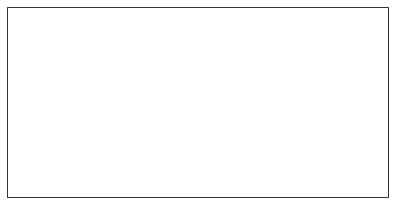

In [64]:
filename=filenames[80]
grid = pyart.io.read_grid(filename, include_fields=['reflectivity'])
fig_dir = '/home/student.unimelb.edu.au/shorte1/Documents/TINT_figures'
uid_ind = '4'

params = {
    'uid_ind': uid_ind, 'line_coords': True, 'center_cell': False, 
    'cell_ind': 10, 'winds': False, 'winds_fn': filename,
    'direction': 'perpendicular', 'crosshair': True, 
    'save_dir': fig_dir, 'line_average': True, 'streamplot': False, 
    'relative_winds': True, 'data_fn': None, 
    'load_line_coords_winds': True, 'fontsize': 14}

tint.visualisation.figures.vertical_cross_section(
    tracks_obj, grid, params=params)

In [6]:
dates = np.arange(
    np.datetime64('2006-02-09 07:00'), 
    np.datetime64('2006-02-09 07:30'),
    np.timedelta64(10, 'm'))

filenames, start_time, end_time = cf.CPOL_files_from_datetime_list(
    dates, base_dir=base_dir)

Gathering files.


In [223]:
params = {
    'uid_ind': None, 'line_coords': False, 'center_cell': False, 
    'cell_ind': 10, 'winds': False, 'winds_fn': filenames, 
    'crosshair': True, 'save_dir': fig_dir, 'alt': 3000, 
    'colorbar_flag': True, 'leg_loc': 1, 'fontsize': 18}

grids = (
    pyart.io.read_grid(fn, include_fields = ['reflectivity'])
    for fn in filenames)

tint.visualisation.animate.animate(
    tracks_obj, grids, params, fig_type='two_level', 
    start_datetime=np.datetime64('2006-02-09 07:00'), 
    end_datetime=np.datetime64('2006-02-09 07:30'))

IndexError: index 0 is out of bounds for axis 0 with size 0

> /home/student.unimelb.edu.au/shorte1/Documents/TINT/tint/visualisation/animate.py(40)check_times()
     38     grid_time = grid_time.astype('datetime64[m]')
     39     if grid_time > date_times[0]:
---> 40         ind = np.argwhere(date_times == grid_time)[0, 0]
     41         if not ind:
     42             print('Object occurs before grids provided. Aborting')

ipdb> q


## Generate WRF crosssections

Generating frame 2006-02-09T05:10:00.000000000


KeyError: 'orientation_alt'

> /home/student.unimelb.edu.au/shorte1/anaconda3/envs/CPOL_analysis/lib/python3.8/site-packages/pandas/core/indexes/base.py(3363)get_loc()
   3361                 return self._engine.get_loc(casted_key)
   3362             except KeyError as err:
-> 3363                 raise KeyError(key) from err
   3364 
   3365         if is_scalar(key) and isna(key) and not self.hasnans:

ipdb> q


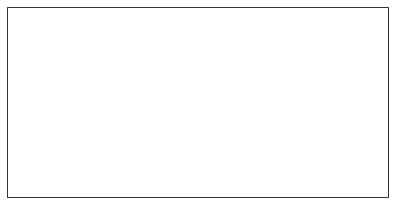

In [10]:
for uid_ind in np.arange(2).astype(str):
    fig_dir = '/home/student.unimelb.edu.au/shorte1/Documents/TINT_figures'

    params = {
        'uid_ind': uid_ind, 'line_coords': True, 'center_cell': False, 
        'cell_ind': 7, 'winds': True, 'winds_fn': filenames, 
        'direction': 'perpendicular', 'crosshair': True, 'save_dir': fig_dir,
        'line_average': True, 'streamplot': True, 'relative_winds': True,
        'data_fn': 'angles', 'load_line_coords_winds': False, 
        'save_ds': True}

    grids = (
        pyart.io.read_grid(fn, include_fields = ['reflectivity'])
        for fn in filenames)

    tint.visualisation.animate.animate(tracks_obj, grids, params)